# Finite Differences Method

In the code below we present the numerical solution for the acoustic wave equation

$$
\partial_t^2 p(\vec{x},t) \ - \ c^2 \Delta p(\vec{x},t) \ = s(\vec{x},t)
$$

assuming constant velocity c and reflecting boundary conditions.

In 2D the constant-density acoustic wave equation is given by

$$
\partial^2_t{p}(x,z,t) \ = \ c^2 (\partial_x^2 p(x,z,t) + \partial_z^2 p(x,z,t)) \ + s(x,z,t)
$$

where the $z$-coordinate is chosen because in many applications the $x-z$ plane is considered a vertical plane with $z$ as depth coordinate. In accordance with the above developments we discretise space-time using

$$
p(x,z,t) \ \rightarrow \ p^n_{i,j} \ = \ p(n dt, i dx, j dz) \ .
$$

Using the 3-point operator for the 2nd derivatives in time leads us to the extrapolation scheme

$$
 \frac{p_{i,j}^{n+1} - 2 p_{i,j}^n + p_{i,j}^{n-1}}{dt^2} \ = \ c^2 ( \partial_x^2 p + \partial_z^2 p) \ + s_{i,j}^n
$$

where on the r.h.s. the space and time dependencies are implicitly assumed and the partial derivatives are approximated by

\begin{equation}
\begin{split}
\partial_x^2 p \ &= \ \frac{p_{i+1,j}^{n} - 2 p_{i,j}^n + p_{i-1,j}^{n}}{dx^2} \\ 
\partial_z^2 p \ &= \ \frac{p_{i,j+1}^{n} - 2 p_{i,j}^n + p_{i,j-1}^{n}}{dz^2}  \ . 
\end{split}
\end{equation}
Note that for a regular 2D grid $dz=dx$ 

Then it leads to the following expression for the pressure of the next time step

$$
 p_{i,j}^{n+1} \ = \ c^2 \frac{dt^2}{dx^2} ( p_{i+1,j}^{n} - 2 p_{i,j}^n + p_{i-1,j}^{n} + p_{i,j+1}^{n} - 2 p_{i,j}^n + p_{i,j-1}^{n}) \ + 2p_{i,j}^{n} - p_{i,j}^{n-1} \ + s_{i,j}^n \cdot dt^2
$$


In [1]:
using Plots

## Parameter configuration 

In [2]:
nx   = 500          # number of grid points in x-direction
nz   = nx           # number of grid points in z-direction

dx   = 1.           # grid point distance in x-direction
dz   = dx           # grid point distance in z-direction
c0   = 580.         # wave velocity in medium (m/s)
isx  = Int(nx / 2.5)  # source location in grid in x-direction
isz  = Int(nz / 2.5)  # source location in grid in z-direction
nt   = 500          # maximum number of time steps
dt   = 0.0010       # time step
f0   = 25. # dominant frequency of the source (Hz)
t0   = 2. / f0 # source time shift

eps  = c0 * dt / dx # epsilon value

println("Source frequency =", f0, "Hz")
println("Stability criterion =", eps)
println("Simulated time: ", nt*dt, " s")

Source frequency =25.0Hz
Stability criterion =0.58
Simulated time: 0.5 s


## Python style Algorithm 

In [3]:
function vectorised_algorithm(nx, nz, nt, dx, dz, dt, c0, isx, isz, f0, t0)

    # Initialize Empty Pressure
    p    = zeros((nz, nx)) # p at time n (now)
    pold = zeros((nz, nx)) # p at time n-1 (past)
    pnew = zeros((nz, nx)) # p at time n+1 (present)

    d2px = zeros((nz, nx)) # 2nd space derivative of p in x-direction
    d2pz = zeros((nz, nx)) # 2nd space derivative of p in z-direction

    # Initialize Velocity Model (assume homogeneous model)
    c = zeros((nz, nx))
    c = c .+ c0             # initialize wave velocity in model

    # Initialize Grid
    x = 1 : nx
    x *= dx             # coordinate in x-direction

    z = 1 : nz
    z *= dz             # coordinate in z-direction

    src  = zeros(nt + 1)

    time = range(0 * dt, stop = nt * dt, length=nt)

    src  = @. -8. * (time - t0) * f0 * (exp(-1.0 * (4*f0)^2 * (time - t0)^2))

    for it in 1 : nt

        # use 3 point operator FD scheme
        for i in 2 : nx - 1

                d2px[i, :] = @. (p[i - 1, :] - 2 * p[i, :] + p[i + 1, :]) / dx^2 

        end

        for j in 2 : nz - 1

                d2pz[:, j] = @. (p[:, j - 1] - 2 * p[:, j] + p[:, j + 1]) / dz^2 

        end


        pnew = @. 2 * p - pold + (c^2) * (dt^2) * (d2pz + d2px)

        pnew[isz, isx] = pnew[isz, isx] + src[it] / (dx * dz) * (dt^2) 

        pold, p = p, pnew

    end

    return p
    
end

vectorised_algorithm (generic function with 1 method)

In [4]:
result = @time vectorised_algorithm(nx, nz, nt, dx, dz, dt, c0, isx, isz, f0, t0);

  7.739276 seconds (6.68 M allocations: 8.801 GiB, 56.41% gc time)


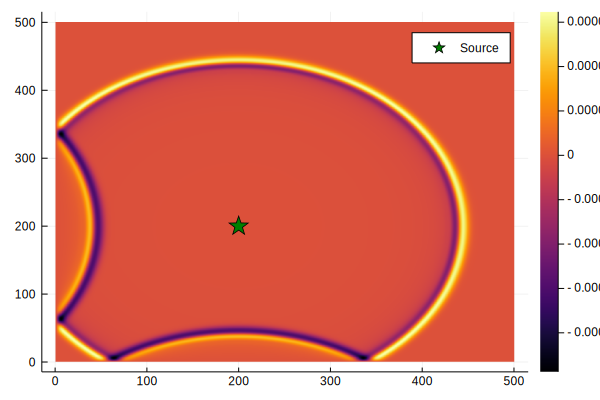

In [5]:
heatmap(result)
scatter!([isx], [isz], color=:green, label="Source", m=:star, markersize=10)

## Julia / C++ style algorithm 

In [6]:
function non_vectorised_algorithm(nx, nz, nt, dx, dz, dt, c0, isx, isz, f0, t0)

    # Initialize Empty Pressure
    p    = zeros((nz, nx)) # p at time n (now)
    pold = zeros((nz, nx)) # p at time n-1 (past)
    pnew = zeros((nz, nx)) # p at time n+1 (present)

    d2px = zeros((nz, nx)) # 2nd space derivative of p in x-direction
    d2pz = zeros((nz, nx)) # 2nd space derivative of p in z-direction

    # Initialize Velocity Model (assume homogeneous model)
    c = zeros((nz, nx))
    c = c .+ c0             # initialize wave velocity in model

    # Initialize Grid
    x = 1 : nx
    x *= dx             # coordinate in x-direction

    z = 1 : nz
    z *= dz             # coordinate in z-direction

    src  = zeros(nt + 1)

    time = range(0 * dt, stop = nt * dt, length=nt)

    src  = @. -8. * (time - t0) * f0 * (exp(-1.0 * (4*f0)^2 * (time - t0)^2))

    for it in 1 : nt

        # use 3 point operator FD scheme
        for i in 2 : nx - 1
            for j in 2 : nz - 1

                d2px[i, j] = (p[i - 1, j] - 2 * p[i, j] + p[i + 1, j]) / dx^2 

                d2pz[i, j] = (p[i, j - 1] - 2 * p[i, j] + p[i, j + 1]) / dz^2 
                
            end
        end

        pnew = @. 2 * p - pold + (c^2) * (dt^2) * (d2pz + d2px)

        pnew[isz, isx] = pnew[isz, isx] + src[it] / (dx * dz) * (dt^2) 

        pold, p = p, pnew

    end
    
    return p
    
end

non_vectorised_algorithm (generic function with 1 method)

In [7]:
result = @time non_vectorised_algorithm(nx, nz, nt, dx, dz, dt, c0, isx, isz, f0, t0);

  2.067119 seconds (250.91 k allocations: 974.145 MiB, 5.69% gc time)


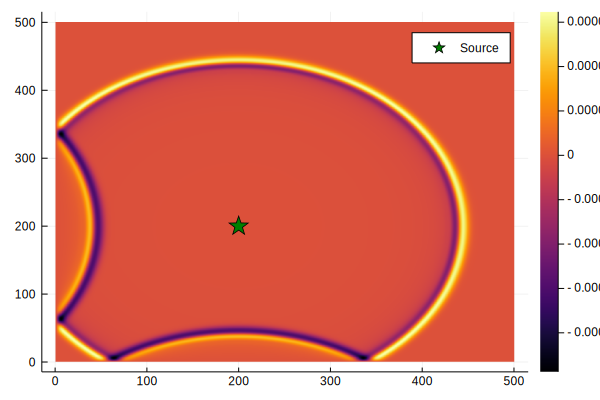

In [8]:
heatmap(result)
scatter!([isx], [isz], color=:green, label="Source", m=:star, markersize=10)

## Animation 

In [9]:
function heatgif(nt, save_frame)
    
    # Initialize Empty Pressure
    p    = zeros((nz, nx)) # p at time n (now)
    pold = zeros((nz, nx)) # p at time n-1 (past)
    pnew = zeros((nz, nx)) # p at time n+1 (present)

    d2px = zeros((nz, nx)) # 2nd space derivative of p in x-direction
    d2pz = zeros((nz, nx)) # 2nd space derivative of p in z-direction

    # Initialize Velocity Model (assume homogeneous model)
    c = zeros((nz, nx))
    c = c .+ c0             # initialize wave velocity in model

    # Initialize Grid
    x = 1 : nx
    x *= dx             # coordinate in x-direction

    z = 1 : nz
    z *= dz             # coordinate in z-direction

    src  = zeros(nt + 1)

    time = range(0 * dt, stop = nt * dt, length=nt)

    src  = @. -8. * (time - t0) * f0 * (exp(-1.0 * (4*f0)^2 * (time - t0)^2))
    
    heatmap(p)
        
    anim = @animate for it in 1 : nt
            
        # use 3 point operator FD scheme
        for i in 2 : nx - 1
            for j in 2 : nz - 1

                d2px[i, j] = (p[i - 1, j] - 2 * p[i, j] + p[i + 1, j]) / dx^2 

                d2pz[i, j] = (p[i, j - 1] - 2 * p[i, j] + p[i, j + 1]) / dz^2 
                
            end
        end

        pnew = @. 2 * p - pold + (c^2) * (dt^2) * (d2pz + d2px)

        pnew[isz, isx] = pnew[isz, isx] + src[it] / (dx * dz) * (dt^2) 

        pold, p = p, pnew
        
        heatmap(p)
        
    end every save_frame
        
    return anim
        
end

heatgif (generic function with 1 method)

In [10]:
#=
anim = @time heatgif(500, 100)
gif(anim)
=#